In [1]:
import random
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load data

In [2]:
data_dir = 'training_mixpanel.txt'
with open(data_dir) as f:
    purchase_data = json.load(f)
data = [item['properties'] for item in purchase_data]
df_raw = pd.DataFrame(data)

# Create encoded DataFrame

First, I extract the unit price in case I decide to use it later. Then I create a new DataFrame which only contains the features which I'll use to build the user profiles. Finally, I encode the customer and product labels to facilitate working with the data later.

In [3]:
# remove unit prices from dataframe
unit_prices = df_raw[['product_id','unit_price']].drop_duplicates(subset='product_id')

In [4]:
# drop features which I won't be using
df = df_raw[['customer_id','product_id','quantity']]

In [ ]:
# encode product and customer labels
enc_product = LabelEncoder()
enc_customer = LabelEncoder()
df.loc[:,'product_id'] = enc_product.fit_transform(df.loc[:,'product_id'])
df.loc[:,'customer_id'] = enc_customer.fit_transform(df.loc[:,'customer_id'])

In [13]:
product_set = set(df['product_id'])
customer_set = set(df['customer_id'])
n_products = len(product_set)
n_customers = len(customer_set)

# Create Model

The model below is very simple. I assume that the purchase history we have is a good enough representation of each users distribution over purchases. To calculate the probability that a user will purchase a certain product, I simply add up the number of purchases of that product, and divide it by the users total number of purchases.

In [35]:
class Model(object):
    
    def __init__(self):
        self.user_profiles = np.zeros((n_customers,n_products), dtype=np.float16)
        
    def build(self,df):
        """
        Create user profiles
        
        Args:
            df: DataFrame of purchase history with
            customer labels under 'customer_id' and
            products purchased under 'product_id'
        """
        for customer in df['customer_id'].unique():
            # get customer purchase history
            df_customer = df[df['customer_id'] == customer]
            purchase_history = df_customer['product_id'].value_counts()
            # calculate the fraction of total products for each product
            total_purchases = float(sum(purchase_history.values))
            fraction_of_purchases = purchase_history/total_purchases
            # add to user profile matrix
            for product in purchase_history.index:
                self.user_profiles[customer][product] = fraction_of_purchases[product]
    
    def save(self, file_name):
        """Saves user profiles to a csv"""
        np.save(file_name, self.user_profiles)
        
    def load(self, file_name): 
        """Saves user profiles from a csv"""
        self.user_profiles = np.load(file_name)
                   
    def predict(self, customer, product):
        """Return customers probability of purchasing product"""
        return self.user_profiles[customer][product]

In [36]:
model = Model()

In [37]:
# build model using DataFrame of purchase history
model.build(df)

In [38]:
# save user profile data
model.save("user_profiles.npy")

In [39]:
# load user profile data
model.load("user_profiles.npy")

# Predictions and Curves

In [40]:
def plot_ROCs(fpr,tpr,roc_auc,classes):
    """Display ROCs"""
    
    if len(classes) > 5:
        sample = random.sample(classes,5)
    else:
        sample = classes
    
    plt.figure()
    for i in sample:
        plt.plot(fpr[i], tpr[i], lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Here I evaluate the model on the training data. I calculate the AUROC on each type of product, print the mean AUROC and display a sample of ROCs. I don't expect the model to perform this well on the testing data, but at the very least it performs well on the training data.

In [43]:
fpr,tpr,thr,roc_auc = {},{},{},{}


# evaluate on all products
products = product_set
# # evalute on a sample of the products
# products = random.sample(product_set,20)

for i in products:
    # get predictions for each consumer x on product i
    predictions = df['customer_id'].apply(lambda x: model.predict(x,i))
    # get each customer's true purchases
    true_purchases = df['product_id'] == i
    # calculate false-positive-rate and true-positive-rate
    fpr[i], tpr[i], thr[i] = roc_curve(true_purchases,predictions)
    # calculate area under ROC
    roc_auc[i] = auc(fpr[i], tpr[i])
    
AUROC_mean = np.mean(list(roc_auc.values()))
print('Mean Area Under ROCs = {0:0.2f}'.format(AUROC_mean))

Mean Area Under ROCs = 0.99


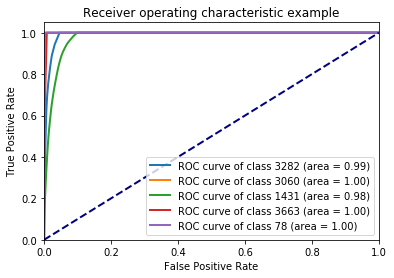

In [44]:
plot_ROCs(fpr,tpr,roc_auc,products)